# Model: Log Firing rates with ADVI

- spike counts are poisson distributed
- firing rates are log-Normally distributed
- firing rates are covariant across units
- noise is also covariant

That is, we want to make the model

$$\begin{align}
N_{tu} &\sim \mathrm{Poisson}(e^{\eta_{tu}}) \\
\eta_{t\cdot} &\sim \mathcal{N}(a_\cdot, S_\eta) \\
a_u &\sim \mathcal{N}(\mu_a, \Sigma_a) \\
S_\eta &\sim \text{Inv-Wishart}(\nu_\eta, \Psi_\eta)
\end{align}$$

In [1]:
using Distributions
using PyPlot
using ForwardDiff
using VinDsl
srand(12345);

Set up some parameters

In [2]:
T = 1000  # number of time steps
U = 10  # units

10

# Make firing rates

In [3]:
baseline = 10.
baseline_sd = 0.10
log_bl = log(baseline)
unit_bl = log_bl + baseline_sd * randn(U);

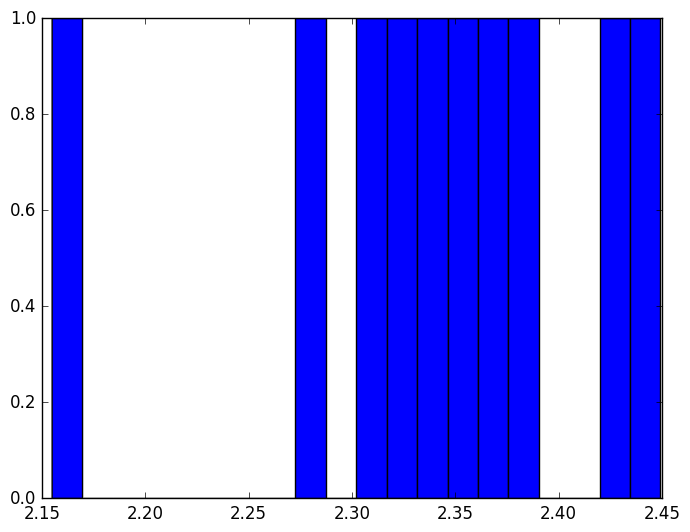

In [4]:
PyPlot.plt[:hist](unit_bl, 20);

In [5]:
fr_log = unit_bl' .+ zeros(T, U)  # firing rate

# make a tridiagonal covariance matrix
Ση = MvNormal(full(SymTridiagonal(ones(U), 0.2 * ones(U - 1))))

eta = fr_log + 0.1 * rand(Ση, T)'
fr = exp(eta);

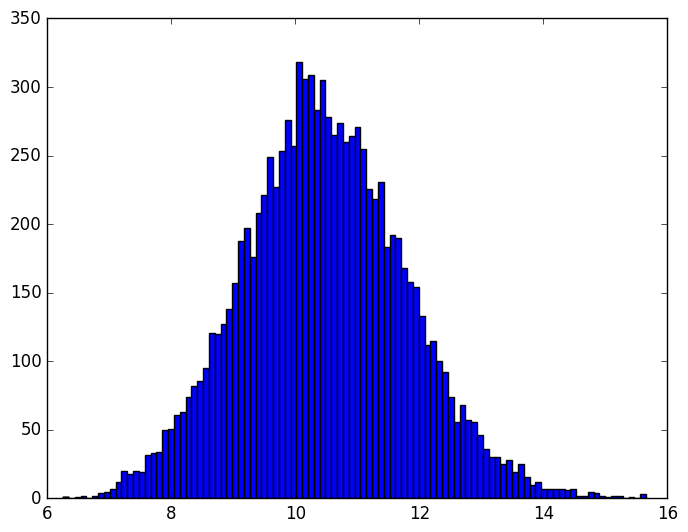

In [6]:
PyPlot.plt[:hist](fr[:], 100);

# Make spikes

In [7]:
spikes = Array{Int}(size(fr)...)
for i in eachindex(fr)
    spikes[i] = rand(Poisson(fr[i]))
end

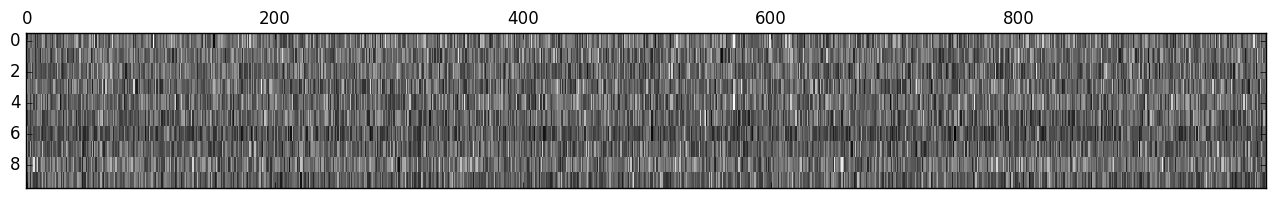

In [8]:
matshow(spikes', aspect="auto", cmap="gray");

# Fleshing out the model:

## Data:
- $N$

## Parameters:
- $\eta$
- $a$ 
- $S$

## Priors:
- $a_u \sim \mathcal{N}(\log(15), 0.1^2)$ (but we want posterior over $a$ to be MvNormal
- $S \sim \text{Inv-Wishart}(U, \mathbb{1}_{U \times U})$

In [16]:
function ELBO(x::Vector)
    ctr = 1
    L = zero(eltype(x))
    
    T_a = RReal()               # type of random variable
    ζ_a = Vector{eltype(x)}(U)          # unconstrained samples
    a = Vector{eltype(x)}(U)            # constrained samples
    
    npars = VinDsl.num_pars_advi(T_a)
    for u in 1:U 
        d_a = VinDsl.normal_from_unconstrained(x[ctr:ctr+npars-1])
        L += H(d_a)
        ctr += npars
        ζ_a[u] = rand(d_a)
        a[u] = constrain(T_a, ζ_a[u])
    end
    
    T_S = RCovMat(U)
    npars = VinDsl.num_pars_advi(T_S)
    d_S = VinDsl.normal_from_unconstrained(x[ctr:ctr+npars-1])
    L += H(d_S)
    ctr += npars
    ζ_S = rand(d_S)
    S = constrain(T_S, ζ_S)
    
    T_η = RRealVec(U)
    ζ_η = Vector{Vector{eltype(x)}}(T)
    η = Vector{Vector{eltype(x)}}(T)
    
    npars = VinDsl.num_pars_advi(T_η)
    for t in 1:T
        d_η = VinDsl.normal_from_unconstrained(x[ctr:ctr+npars-1])
        L += H(d_η)
        ctr += npars
        ζ_η[t] = rand(d_η)
        η[t] = constrain(T_η, ζ_η[t])
    end
    
    # run code for transformed pars
    
    ######### Jacobeans
    
    for u in 1:U
        L += logdetjac(T_a, ζ_a[u])
    end
    
    L += logdetjac(T_S, ζ_S)
    
    for t in 1:T
        L += logdetjac(T_η, ζ_η[t])
    end
    
    ########## E[log p]
    for u in 1:U
        L += logpdf(Normal(log(15.), 0.1), a[u])
    end
    L += logpdf(InverseWishart(U, eye(U)), S)
    for t in 1:T
        for u in 1:U
            L += logpdf(Poisson(exp(η[t][u])), spikes[t, u])
        end
    end
    
    L
end

ELBO (generic function with 1 method)

In [17]:
npars = U * VinDsl.num_pars_advi(RReal()) + VinDsl.num_pars_advi(InverseWishart(U, eye(U))) +
T * VinDsl.num_pars_advi(RRealVec(U))
xx = randn(npars)
ELBO(xx)

-6.138272298723824e24

# Initialize priors

## Baseline

In [9]:
μ_a = log(15.)
σ_a = 0.1
τ_a = 1/σ_a^2
a_prior = NormalCanon(μ_a * τ_a, τ_a)

Distributions.NormalCanon{Float64}(η=270.805020110221, λ=99.99999999999999, μ=2.7080502011022105)

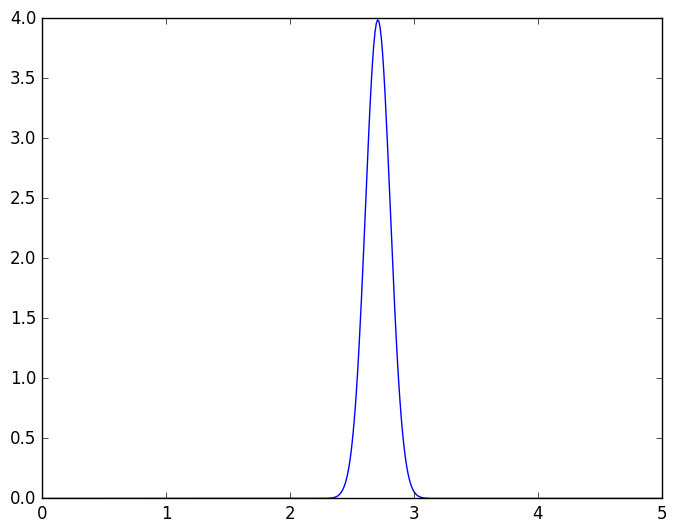

In [10]:
xx = linspace(0, 5, 500)
plot(xx, pdf(a_prior, xx));

## Noise

In [11]:
τ_prior = Gamma(2, 1/20)

Distributions.Gamma{Float64}(α=2.0, θ=0.05)

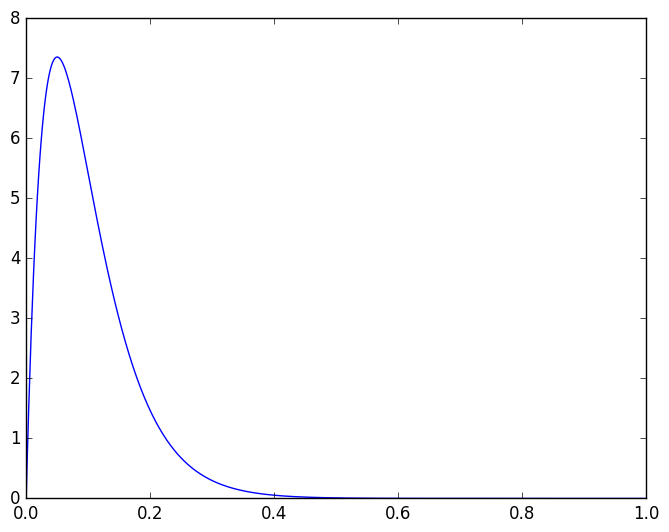

In [12]:
xx = linspace(0, 1, 500)
plot(xx, pdf(τ_prior, xx));

# Make VinDsl model

To do this, we first need to define a factor for the Poisson distribution parameterized in terms of log firing rate:

In [13]:
@deffactor LogPoissonAltFactor [n, x] begin
    sum(E(n)' .* E(x) - lgamma(E(n)' + 1) - exp(E(x) + 0.5 * V(x)))
end

value (generic function with 12 methods)

Now let's define a posterior model:

$$\begin{align}
\eta_{t\cdot} &\sim \mathcal{N}((\mu_\eta)_{t\cdot}, (\Sigma_\eta)) \\
a_\cdot &\sim \mathcal{N}((\mu_a), (\Sigma_a)) \\
\Lambda_\eta &\sim \mathrm{Wishart}(\nu, S)
\end{align}$$

In [14]:
n[t, u] ~ Const(spikes)
η[u, t] ~ MvNormalCanon([log(squeeze(spikes[t, :], 1) + 0.1) for t in 1:T], [5 * eye(U) for _ in 1:T])  # indices reversed because u must be inner
a[u] ~ MvNormalCanon(zeros(U), 0.5 * eye(U))
Λ[u, u] ~ Wishart(U, 0.5 * eye(U))
m_a[u] ~ Const(zeros(U))
P_a[u, u] ~ Const(1 * eye(U))
ν ~ Const(U)
S ~ Const(0.1 * eye(U))

VinDsl.ConstantNode{Float64}(:S,Symbol[],Symbol[],10x10 Array{Float64,2}:
 0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.1)

along with some factors...

In [15]:
a_prior = @factor LogMvNormalCanonFactor a m_a P_a
a_entropy = @factor EntropyFactor a
Λ_prior = @factor LogWishartFactor Λ ν S
Λ_entropy = @factor EntropyFactor Λ
η_entropy = @factor EntropyFactor η
η_lik = @factor LogMvNormalCanonFactor η a Λ
obs = @factor LogPoissonAltFactor n η
m = VBModel([n, η, a, Λ, m_a, P_a, ν, S], [a_prior, a_entropy, Λ_prior, Λ_entropy, η_entropy, η_lik, obs]);

In [16]:
ELBO(m::VBModel) = sum([value(f) for f in m.factors])

ELBO (generic function with 1 method)

In [17]:
[(n.name, s) for (n, s) in m.update_strategy]

8-element Array{Tuple{Any,Any},1}:
 (:n,:constant)  
 (:P_a,:constant)
 (:η,:undefined) 
 (:ν,:constant)  
 (:Λ,:conjugate) 
 (:S,:constant)  
 (:a,:conjugate) 
 (:m_a,:constant)

In [18]:
m.update_strategy[η] = :cg

:cg

In [19]:
ELBO(m)

-2008.2170686332129

Run inference:

In [20]:
@time begin 
niter = 10
display(ELBO(m))
for _ in 1:niter
    update!(m)
    display(ELBO(m))
end
end

-2008.2170686332129

-715.7328410341449

-390.7887592705023

-382.46935050030004

-382.32931951902367

-382.3275631826517

-382.3272104261746

-382.3271944818864

-382.3271919446841

-382.3271904799553

-382.32718923998783

218.929445 seconds (642.47 M allocations: 815.639 GB, 36.45% gc time)


In [21]:
E(a.data)

1-element Array{Array{Float64,1},1}:
 [1.9967988648636088,1.8944220093792221,2.0799237698629116,2.155000237442564,2.2253803871964513,1.9916173728640154,1.8941695151209883,2.1319123488039495,2.1891215449059613,1.9326735134578044]

In [22]:
unit_bl

10-element Array{Float64,1}:
 2.41982
 2.38786
 2.34414
 2.35423
 2.37116
 2.33081
 2.15488
 2.31526
 2.44923
 2.28677

In [23]:
inv(E(Λ.data)[1])

10x10 Array{Float64,2}:
 0.619951     0.00874007   0.0112717   …  0.0142618    0.0116438  
 0.00874007   0.710402     0.0100818      0.0258869    0.0135717  
 0.0112717    0.0100818    0.618992       0.00352482   0.0161693  
 0.0110329    0.0212286   -0.00239211     0.0136217    0.000173454
 0.00864913  -0.013543     0.0123438      0.00677861  -0.000893453
 0.0283782    0.036386     0.00577966  …  0.00536335   0.0197763  
 0.00117245   0.0584363    0.00610296     0.0141686    0.0213239  
 0.0116747    0.015319     0.00790655     0.0159761   -0.00712579 
 0.0142618    0.0258869    0.00352482     0.602879     0.00898287 
 0.0116438    0.0135717    0.0161693      0.00898287   0.601394   

In [24]:
Ση.Σ

PDMats.PDMat{Float64,Array{Float64,2}}(10,10x10 Array{Float64,2}:
 1.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.2  1.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.2  1.0  0.2  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.2  1.0  0.2  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.2  1.0  0.2  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.2  1.0  0.2  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.2  1.0  0.2  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.2  1.0  0.2  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  1.0  0.2
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.2  1.0,Base.LinAlg.Cholesky{Float64,Array{Float64,2}} with factor:
10x10 UpperTriangular{Float64,Array{Float64,2}}:
 1.0  0.2       0.0       0.0       0.0       …  0.0       0.0       0.0     
 0.0  0.979796  0.204124  0.0       0.0          0.0       0.0       0.0     
 0.0  0.0       0.978945  0.204302  0.0          0.0       0.0       0.0     
 0.0  0.0       0.0       0.978908  0.204309     0.0       0.0       0.0     
 0.0  0.0    